This is an exploration of the whole series of mortality data from the CDC.

First let's configure logging, including turning off the preconfigured loggers.

In [1]:
from logging import Formatter
from logging import getLogger
from logging import INFO
from logging import StreamHandler

logger = getLogger(__name__)
logger.handlers.clear()
handler = StreamHandler()
handler.setLevel(INFO)
handler.setFormatter(Formatter('%(name)s - %(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(handler)

Let's list all the files. We note that we have data files in CSV format representing the years 2005-2015, inclusive (11 years).

In [2]:
from os import walk
from os.path import join

for dirname, _, filenames in walk('../input/mortality/'):
    for filename in filenames:
        logger.info(msg=join(dirname, filename))

__main__ - 2023-06-16 14:38:54,083 - INFO - ../input/mortality/2014_codes.json
__main__ - 2023-06-16 14:38:54,085 - INFO - ../input/mortality/2007_data.csv
__main__ - 2023-06-16 14:38:54,085 - INFO - ../input/mortality/2007_codes.json
__main__ - 2023-06-16 14:38:54,086 - INFO - ../input/mortality/2012_data.csv
__main__ - 2023-06-16 14:38:54,087 - INFO - ../input/mortality/2010_data.csv
__main__ - 2023-06-16 14:38:54,089 - INFO - ../input/mortality/2009_data.csv
__main__ - 2023-06-16 14:38:54,090 - INFO - ../input/mortality/2011_data.csv
__main__ - 2023-06-16 14:38:54,091 - INFO - ../input/mortality/2015_codes.json
__main__ - 2023-06-16 14:38:54,092 - INFO - ../input/mortality/2011_codes.json
__main__ - 2023-06-16 14:38:54,093 - INFO - ../input/mortality/2006_data.csv
__main__ - 2023-06-16 14:38:54,094 - INFO - ../input/mortality/2010_codes.json
__main__ - 2023-06-16 14:38:54,095 - INFO - ../input/mortality/2005_data.csv
__main__ - 2023-06-16 14:38:54,096 - INFO - ../input/mortality/200

In [3]:
from json import load
with open(file='../input/mortality/2013_codes.json', mode='r', encoding='utf-8', ) as codes_fp:
    codes = load(fp=codes_fp,)
for key in codes.keys():
    logger.info(msg=key)

__main__ - 2023-06-16 14:38:54,143 - INFO - resident_status
__main__ - 2023-06-16 14:38:54,143 - INFO - education_1989_revision
__main__ - 2023-06-16 14:38:54,144 - INFO - education_2003_revision
__main__ - 2023-06-16 14:38:54,145 - INFO - education_reporting_flag
__main__ - 2023-06-16 14:38:54,146 - INFO - month_of_death
__main__ - 2023-06-16 14:38:54,147 - INFO - sex
__main__ - 2023-06-16 14:38:54,148 - INFO - age_substitution_flag
__main__ - 2023-06-16 14:38:54,149 - INFO - age_recode_52
__main__ - 2023-06-16 14:38:54,150 - INFO - age_recode_27
__main__ - 2023-06-16 14:38:54,151 - INFO - age_recode_12
__main__ - 2023-06-16 14:38:54,152 - INFO - infant_age_recode_22
__main__ - 2023-06-16 14:38:54,153 - INFO - place_of_death_and_decedents_status
__main__ - 2023-06-16 14:38:54,154 - INFO - marital_status
__main__ - 2023-06-16 14:38:54,157 - INFO - day_of_week_of_death
__main__ - 2023-06-16 14:38:54,159 - INFO - current_data_year
__main__ - 2023-06-16 14:38:54,160 - INFO - injury_at_wor

If we try to load up all of the data we may run out of memory, so let's start by doing one big load of just the columns we initially want across all 11 years; we'll use a list comprehension and concat() to avoid saving two copies of the data, and we'll hide the progress information in our CSV reading code. We have one year where one column is named differently, so we have to modify the used columns based on the year.

In [4]:
from pandas import concat
from pandas import read_csv
from pandas import DataFrame

USECOLS = ['activity_code', 'autopsy', 'current_data_year', 'day_of_week_of_death', 'detail_age', 'education_reporting_flag',
           'injury_at_work', 'manner_of_death', 'marital_status', 'method_of_disposition', 'month_of_death', 
           'place_of_death_and_decedents_status', 'race', 'resident_status', 'sex']

def get_usecols(year: int) -> list:
    return sorted(USECOLS + ['icd_code_10th_revision']) if year != 2012 else sorted(USECOLS + ['icd_code_10'])

def read(filename: str, usecols: list, ) -> DataFrame:
    logger = getLogger(name=__name__)
    logger.info(msg='reading {}'.format(filename))
    result_df = read_csv(filepath_or_buffer=filename, low_memory=False, usecols=usecols, )
    if 'icd_code_10' in result_df.columns:
        result_df = result_df.rename(columns={'icd_code_10': 'icd_code_10th_revision'})
    logger.info(msg='read {} rows.'.format(len(result_df)))
    logger.debug(msg=result_df.columns)
    return result_df

df = concat([read(filename='../input/mortality/{}_data.csv'.format(year),
                  usecols=get_usecols(year), ) for year in range(2005, 2016)])

# we are only interested in the codes for which we have DataFrame columns
codes = {key: value for key, value in codes.items() if key in df.columns}

__main__ - 2023-06-16 14:38:54,250 - INFO - reading ../input/mortality/2005_data.csv
__main__ - 2023-06-16 14:39:11,699 - INFO - read 2452506 rows.
__main__ - 2023-06-16 14:39:11,701 - INFO - reading ../input/mortality/2006_data.csv
__main__ - 2023-06-16 14:39:28,590 - INFO - read 2430725 rows.
__main__ - 2023-06-16 14:39:28,591 - INFO - reading ../input/mortality/2007_data.csv
__main__ - 2023-06-16 14:39:45,544 - INFO - read 2428343 rows.
__main__ - 2023-06-16 14:39:45,545 - INFO - reading ../input/mortality/2008_data.csv
__main__ - 2023-06-16 14:40:02,515 - INFO - read 2476811 rows.
__main__ - 2023-06-16 14:40:02,516 - INFO - reading ../input/mortality/2009_data.csv
__main__ - 2023-06-16 14:40:19,385 - INFO - read 2441219 rows.
__main__ - 2023-06-16 14:40:19,386 - INFO - reading ../input/mortality/2010_data.csv
__main__ - 2023-06-16 14:40:36,534 - INFO - read 2472542 rows.
__main__ - 2023-06-16 14:40:36,535 - INFO - reading ../input/mortality/2011_data.csv
__main__ - 2023-06-16 14:40

Let's see how much data we have.

In [5]:
logger.info(msg='row count: {:,}'.format(len(df)))
logger.info(msg='bytes: {:,}'.format(df.memory_usage().sum()))

__main__ - 2023-06-16 14:42:14,451 - INFO - row count: 27,720,673
__main__ - 2023-06-16 14:42:14,456 - INFO - bytes: 3,770,011,528


Let's make our first graph: a plot of the total deaths for each year.
And let's use lmplot() to include a trend line.

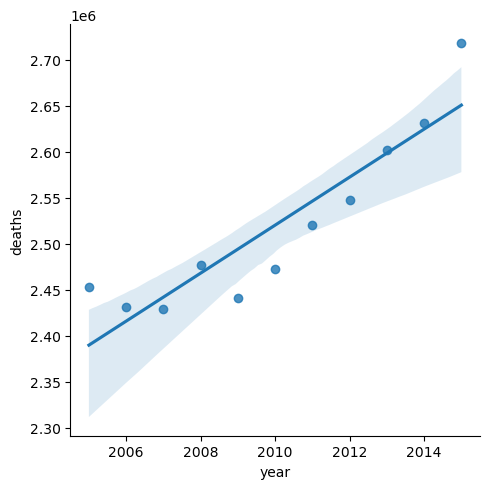

In [6]:
from seaborn import lmplot
%matplotlib inline
annual_total_df = df['current_data_year'].value_counts().to_frame(name='deaths').reset_index()
annual_total_df.columns = ['year', 'deaths']
lmplot(data=annual_total_df, x='year', y='deaths',)

Let's try splitting out male and female deaths.

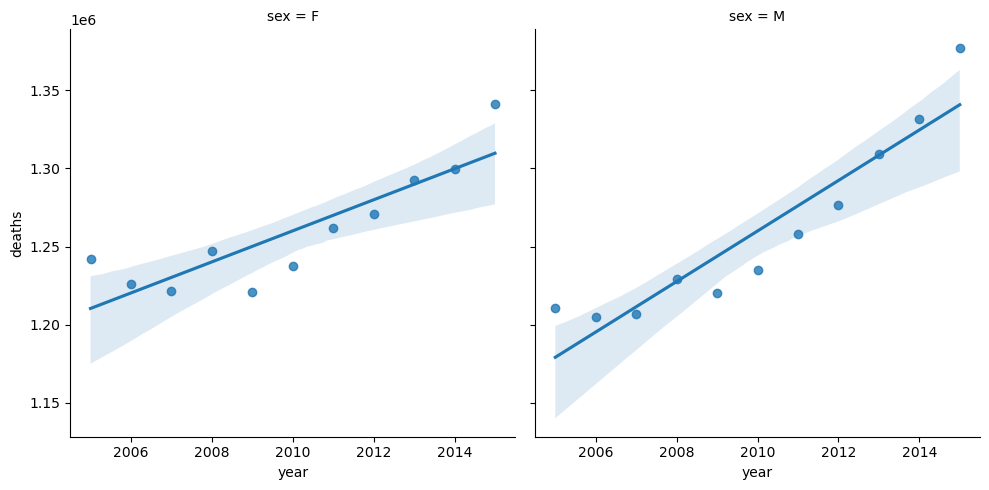

In [7]:
plot_df = df.groupby(by=['current_data_year', 'sex']).size().reset_index().rename(columns={'current_data_year': 'year', 0: 'deaths'})
lmplot(col='sex', data=plot_df, x='year', y='deaths',)
column = 'sex'
for item in plot_df[column].unique():
    title = '{} = {}'.format(column, item)
    if title in annual_total_df.columns:
        annual_total_df = annual_total_df.drop(columns=[title],)
    annual_total_df = annual_total_df.merge(right=plot_df[plot_df[column] == item], on='year').drop(columns=[column]).rename(columns={'deaths' : title})

Let's get the race names, add a column for the race name, and split out the deaths by race. Here we are shortening some group names and combining some groups.

In [8]:
to_replace = {int(key): value for key, value in codes['race'].items()}
to_replace[3] = 'Native American'
to_replace[6] = 'Hawaiian'
to_replace[8] = 'Other Asian'
to_replace[68] = 'Other Asian'
to_replace[78] = 'Other Asian'
df['race_name'] = df['race'].replace(to_replace=to_replace)

__main__ - 2023-06-16 14:42:41,537 - INFO - 
    year  deaths_x  deaths_y  sex = M  Asian Indian   Black  Chinese  \
0   2015   2718198   1341033  1377165          8131  320759    14526   
1   2014   2631171   1299710  1331461          6778  309504    13297   
2   2013   2601452   1292382  1309070          6260  303461    12934   
3   2012   2547864   1271045  1276819          5574  295769    12414   
4   2011   2519842   1261876  1257966          5020  290593    11715   
5   2008   2476811   1247414  1229397          3992  289629    10301   
6   2010   2472542   1237340  1235202          4723  287434    10974   
7   2005   2452506   1241896  1210610          3326  293389     9633   
8   2009   2441219   1221099  1220120          4352  287137    10447   
9   2006   2430725   1225794  1204931          3550  290461     9798   
10  2007   2428343   1221287  1207056          3712  290121     9905   

    Filipino  Guamanian  Hawaiian  Japanese  Korean  Native American  \
0      12041      

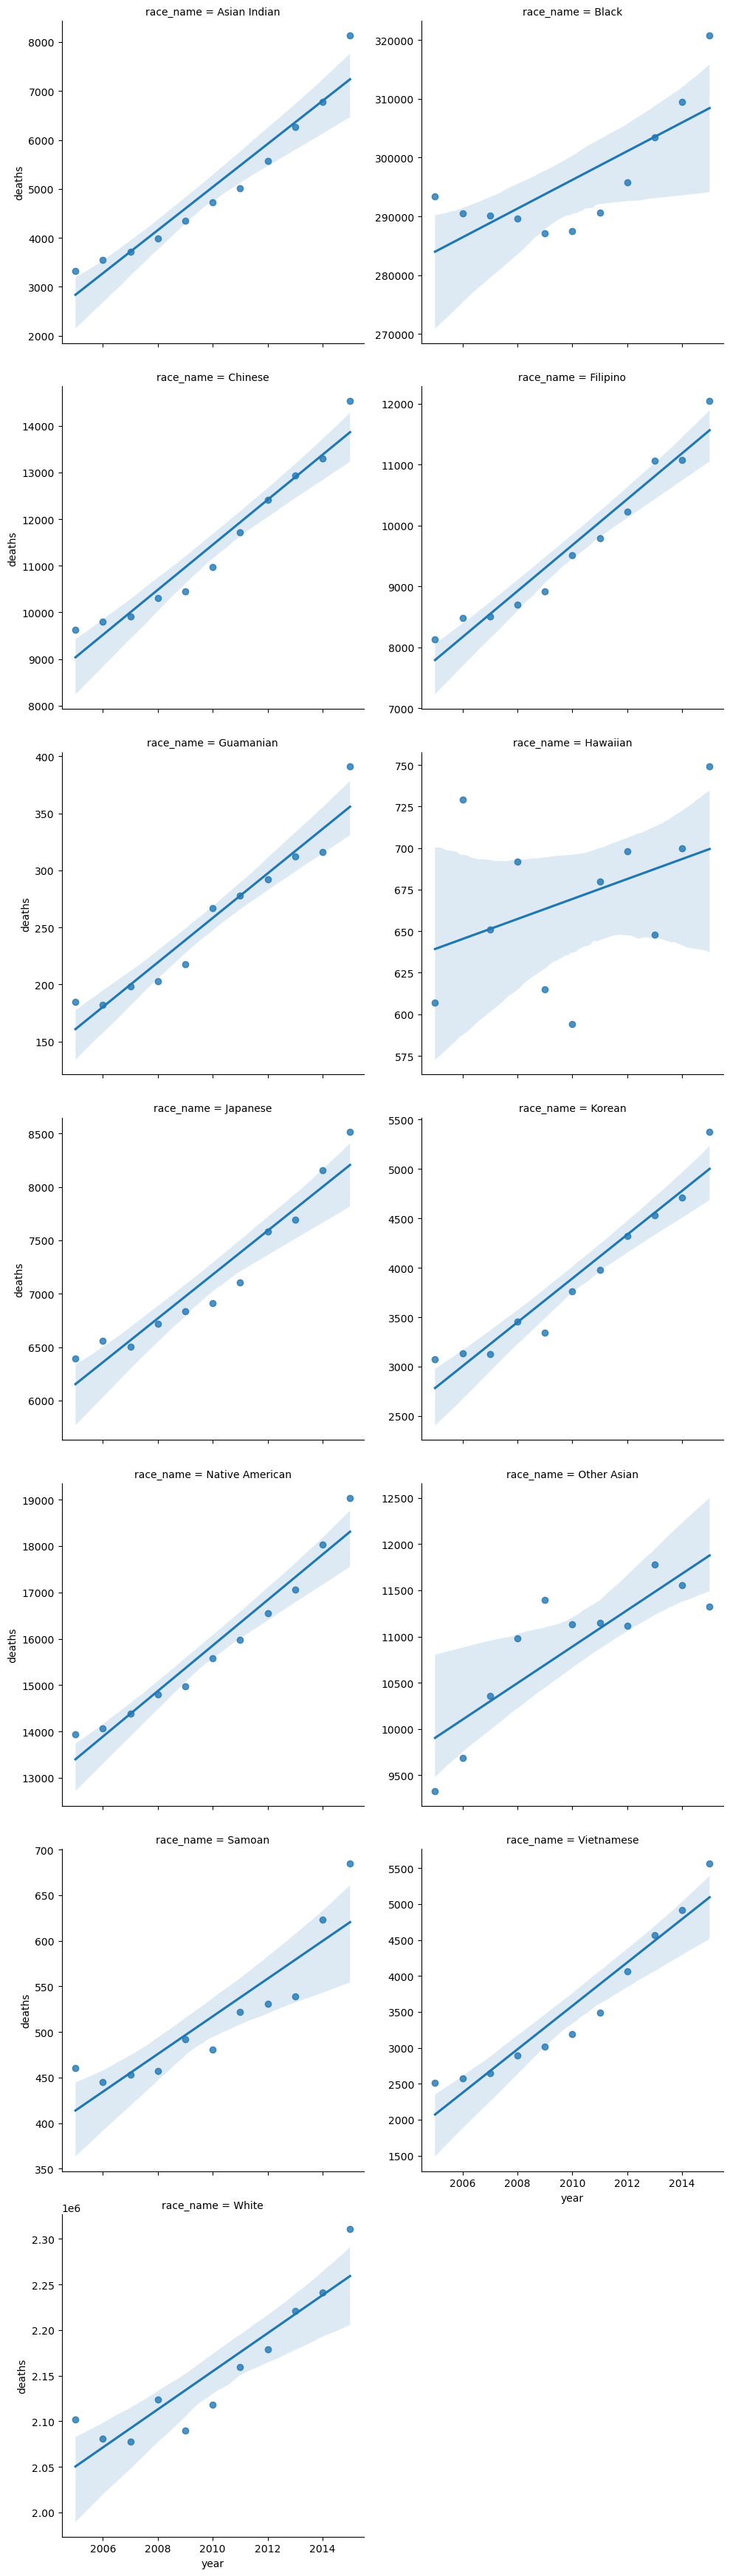

In [9]:
plot_df = df.groupby(by=['current_data_year', 'race_name']).size().reset_index().rename(columns={'current_data_year': 'year', 0: 'deaths'})
lmplot(col='race_name', col_wrap=2, data=plot_df, facet_kws=dict(sharey=False), seed=1, x='year', y='deaths',)
column = 'race_name'
for item in plot_df[column].unique():
    title = '{}'.format(item)
    if title in annual_total_df.columns:
        annual_total_df = annual_total_df.drop(columns=[title],)
    annual_total_df = annual_total_df.merge(right=plot_df[plot_df[column] == item], on='year').drop(columns=[column]).rename(columns={'deaths' : title})
logger.info(msg='\n{}'.format(annual_total_df))

<Axes: >

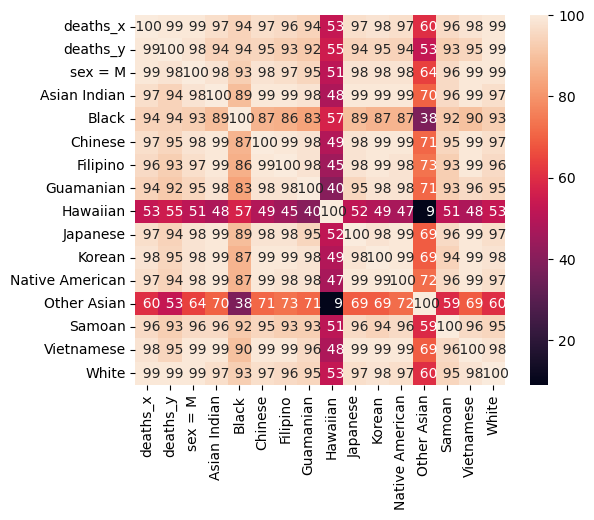

In [10]:
from seaborn import heatmap
corr_df = data=(100 * annual_total_df.drop(columns=['year'],).corr()).astype(int)
heatmap(annot=True, data=corr_df, fmt='4d', square=True, )

<Axes: >

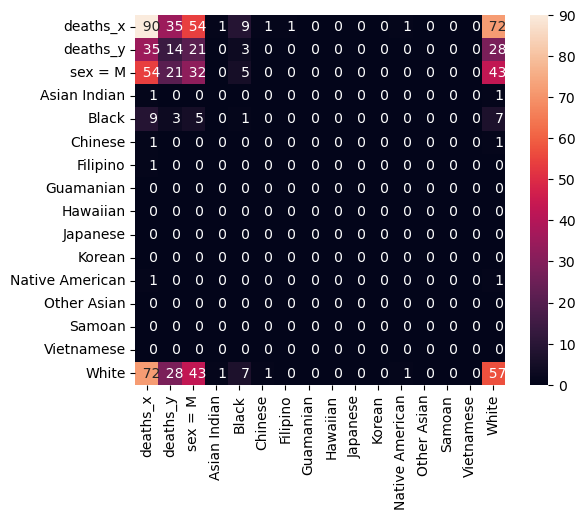

In [11]:
cov_df = data=(1e-8 * annual_total_df.drop(columns=['year'],).cov()).astype(int)
heatmap(annot=True, data=cov_df, fmt='4d', square=True, )

In [12]:
icd_counts = list(df['icd_code_10th_revision'].value_counts().to_dict().items())
logger.info(icd_counts[:10])

__main__ - 2023-06-16 14:42:51,456 - INFO - [('I251', 1936376), ('C349', 1723585), ('I219', 1388327), ('J449', 1136896), ('F03', 1049358), ('G309', 896200), ('I64', 755369), ('I250', 657654), ('I500', 607764), ('J189', 512409)]


TODO: add the covariance for sex and race
TODO: start digging into the top ICD codes

In [13]:
logger.info(msg='done')

__main__ - 2023-06-16 14:42:51,554 - INFO - done
